<a href="https://colab.research.google.com/github/ifymedebem/QCES/blob/main/LNM_Project2_transport_9992G.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

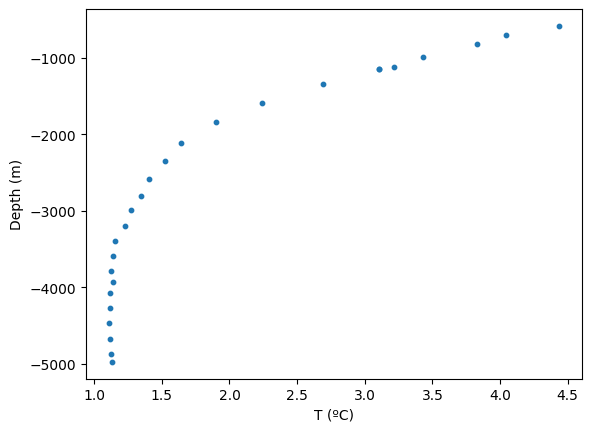

In [2]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation.

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


2025-11-12 18:46:00,529 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


Text(0, 0.5, 'Depth (m)')

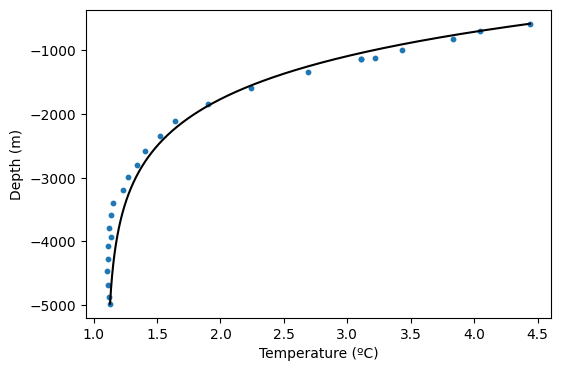

In [3]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa=0.9*1e-4 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water.

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data.

ANSWER - A diffusivity of 0.9* 1e**-4 fits the data best and as noted by Munk (1966), it is magnitudes larger than the molecular value. The ability of this model to fit the data implies that our data remains within the assumptions laid by the steady state model which are constant upwelling and constant diffusivity. The fact that it does not fit perfectly shows that this assumption is wrong and that is why the model fails to fit the data exactly.

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, $D$ is a reference depth where $\kappa=\kappa_0$, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 8.7e-01/s


2025-11-12 18:46:02,666 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 8.7e-01/s


Text(0, 0.5, 'Depth (m)')

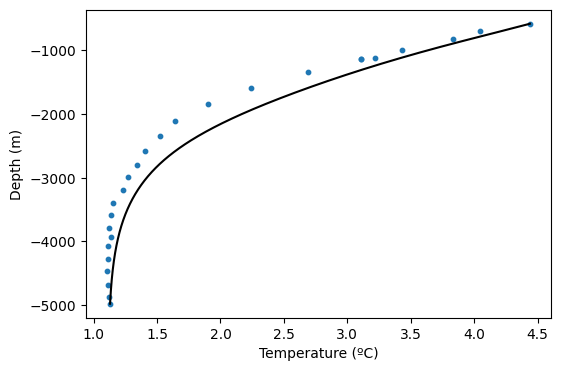

In [4]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 0 # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa['g']=1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/667) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the requied vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

Answer - If w=0, this means that governing equation will be equal to 0 and the system is a diffusive system. However, the value of kappa is constant. Therefore, for the second derivative of temperature against depth to be 0, the first derivative of temperature (Temperature gradient) needs to be a constant. This confirms that temperature has a linear profile, meaning that the diffusive heat flux is also constant. The optimal w is sensitive between specific ranges of kappa.

Optimal w = 0.8 * 10**-8

Observations;
@D = 5000, w = 0.8*10-**-8
@D = 10,000, w = 1.2*10**-8
At an increase in D, there is a corresponding increase in w, this confirms the increase in upwelling with depth.

At the optimal value of w, as the value of D is decreased, the diffusivity increases. Alternatively, as I increase the value of D, the the diffusivity decreases.

As proposed by Ferrari et al (2016), this implies that regions with rough topography like the edges of the ocean boundaries and the bottom of the ocean have increased diffusivity due to shorter reference depths as well as increased turbulence due to the rough topography which is necessary for upwelling, while regions with smoother topography have a reduced diffusivity as the reference depth is larger and there is no turbulence, thus accounting for downwelling.



## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a spatially-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [5]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2025-11-12 18:46:03,928 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:__main__:Starting main loop


2025-11-12 18:46:03,934 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-12 18:46:05,147 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-12 18:46:05,173 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-12 18:46:05,197 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-12 18:46:05,222 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-12 18:46:05,247 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-12 18:46:05,272 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-12 18:46:05,297 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-12 18:46:05,322 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-12 18:46:05,347 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-12 18:46:05,372 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-12 18:46:05,399 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-12 18:46:05,428 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-12 18:46:05,455 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-12 18:46:05,480 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-12 18:46:05,506 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-12 18:46:05,532 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-12 18:46:05,562 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-12 18:46:05,588 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-12 18:46:05,614 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-12 18:46:05,640 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-12 18:46:05,667 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-12 18:46:05,694 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-12 18:46:05,726 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-12 18:46:05,760 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-12 18:46:05,785 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-12 18:46:05,810 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-12 18:46:05,835 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-12 18:46:05,860 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-12 18:46:05,886 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-12 18:46:05,913 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-12 18:46:05,942 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-12 18:46:05,969 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-12 18:46:05,996 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-12 18:46:06,022 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-12 18:46:06,048 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-12 18:46:06,074 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-12 18:46:06,099 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-12 18:46:06,124 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-12 18:46:06,151 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-12 18:46:06,176 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-12 18:46:06,207 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-12 18:46:06,235 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-12 18:46:06,260 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-12 18:46:06,285 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-12 18:46:06,310 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-12 18:46:06,336 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-12 18:46:06,361 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-12 18:46:06,386 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-12 18:46:06,412 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-12 18:46:06,439 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-12 18:46:06,467 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-12 18:46:06,493 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-12 18:46:06,519 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-12 18:46:06,546 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-12 18:46:06,572 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-12 18:46:06,597 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-12 18:46:06,624 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-12 18:46:06,650 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-12 18:46:06,676 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-12 18:46:06,701 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-12 18:46:06,730 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-12 18:46:06,763 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-12 18:46:06,797 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-12 18:46:06,823 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-12 18:46:06,850 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-12 18:46:06,878 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-12 18:46:06,905 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-12 18:46:06,933 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-12 18:46:06,959 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-12 18:46:06,988 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-12 18:46:07,017 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-12 18:46:07,046 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-12 18:46:07,073 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-12 18:46:07,101 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-12 18:46:07,128 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-12 18:46:07,155 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-12 18:46:07,185 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-12 18:46:07,205 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-12 18:46:07,207 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-12 18:46:07,209 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.5861 sec


2025-11-12 18:46:07,211 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5861 sec


INFO:solvers:Warmup time (iter 0-10): 1.234 sec


2025-11-12 18:46:07,213 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.234 sec


INFO:solvers:Run time (iter 10-end): 2.036 sec


2025-11-12 18:46:07,217 solvers 0/1 INFO :: Run time (iter 10-end): 2.036 sec


INFO:solvers:CPU time (iter 10-end): 0.0005656 cpu-hr


2025-11-12 18:46:07,220 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0005656 cpu-hr


INFO:solvers:Speed: 6.455e+06 mode-stages/cpu-sec


2025-11-12 18:46:07,222 solvers 0/1 INFO :: Speed: 6.455e+06 mode-stages/cpu-sec


## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command:

`conda install -c conda-forge ffmpeg`

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-12 18:46:07,442 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpld7yp0zy/temp.m4v


2025-11-12 18:46:07,445 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpld7yp0zy/temp.m4v


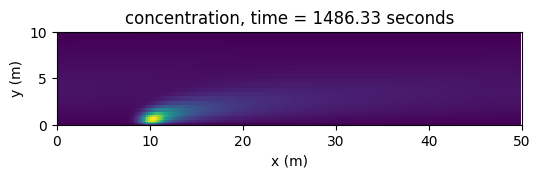

In [6]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
### Advective/diffusive timescales
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2025-11-12 18:46:23,474 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


INFO:__main__:Starting simulation U0=0.1, kappa=0.01, dt=0.1


2025-11-12 18:46:23,479 __main__ 0/1 INFO :: Starting simulation U0=0.1, kappa=0.01, dt=0.1


INFO:solvers:Simulation stop time reached.


2025-11-12 18:46:59,024 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 15001


2025-11-12 18:46:59,027 solvers 0/1 INFO :: Final iteration: 15001


INFO:solvers:Final sim time: 1500.0999999997312


2025-11-12 18:46:59,029 solvers 0/1 INFO :: Final sim time: 1500.0999999997312


INFO:solvers:Setup time (init - iter 0): 0.2485 sec


2025-11-12 18:46:59,033 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2485 sec


INFO:solvers:Warmup time (iter 0-10): 0.05647 sec


2025-11-12 18:46:59,035 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.05647 sec


INFO:solvers:Run time (iter 10-end): 35.49 sec


2025-11-12 18:46:59,037 solvers 0/1 INFO :: Run time (iter 10-end): 35.49 sec


INFO:solvers:CPU time (iter 10-end): 0.009858 cpu-hr


2025-11-12 18:46:59,040 solvers 0/1 INFO :: CPU time (iter 10-end): 0.009858 cpu-hr


INFO:solvers:Speed: 7.325e+06 mode-stages/cpu-sec


2025-11-12 18:46:59,042 solvers 0/1 INFO :: Speed: 7.325e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2025-11-12 18:46:59,306 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


INFO:__main__:Starting simulation U0=0.5, kappa=0.01, dt=0.1


2025-11-12 18:46:59,312 __main__ 0/1 INFO :: Starting simulation U0=0.5, kappa=0.01, dt=0.1


INFO:solvers:Simulation stop time reached.


2025-11-12 18:47:34,975 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 15001


2025-11-12 18:47:34,978 solvers 0/1 INFO :: Final iteration: 15001


INFO:solvers:Final sim time: 1500.0999999997312


2025-11-12 18:47:34,980 solvers 0/1 INFO :: Final sim time: 1500.0999999997312


INFO:solvers:Setup time (init - iter 0): 0.249 sec


2025-11-12 18:47:34,982 solvers 0/1 INFO :: Setup time (init - iter 0): 0.249 sec


INFO:solvers:Warmup time (iter 0-10): 0.05718 sec


2025-11-12 18:47:34,984 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.05718 sec


INFO:solvers:Run time (iter 10-end): 35.61 sec


2025-11-12 18:47:34,985 solvers 0/1 INFO :: Run time (iter 10-end): 35.61 sec


INFO:solvers:CPU time (iter 10-end): 0.009891 cpu-hr


2025-11-12 18:47:34,987 solvers 0/1 INFO :: CPU time (iter 10-end): 0.009891 cpu-hr


INFO:solvers:Speed: 7.301e+06 mode-stages/cpu-sec


2025-11-12 18:47:34,989 solvers 0/1 INFO :: Speed: 7.301e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+00/s


2025-11-12 18:47:35,226 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+00/s


INFO:__main__:Starting simulation U0=2.0, kappa=0.01, dt=0.09765625


2025-11-12 18:47:35,230 __main__ 0/1 INFO :: Starting simulation U0=2.0, kappa=0.01, dt=0.09765625


INFO:solvers:Simulation stop time reached.


2025-11-12 18:48:12,202 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 15360


2025-11-12 18:48:12,204 solvers 0/1 INFO :: Final iteration: 15360


INFO:solvers:Final sim time: 1500.0


2025-11-12 18:48:12,205 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2186 sec


2025-11-12 18:48:12,206 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2186 sec


INFO:solvers:Warmup time (iter 0-10): 0.05744 sec


2025-11-12 18:48:12,208 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.05744 sec


INFO:solvers:Run time (iter 10-end): 36.91 sec


2025-11-12 18:48:12,210 solvers 0/1 INFO :: Run time (iter 10-end): 36.91 sec


INFO:solvers:CPU time (iter 10-end): 0.01025 cpu-hr


2025-11-12 18:48:12,211 solvers 0/1 INFO :: CPU time (iter 10-end): 0.01025 cpu-hr


INFO:solvers:Speed: 7.21e+06 mode-stages/cpu-sec


2025-11-12 18:48:12,212 solvers 0/1 INFO :: Speed: 7.21e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2025-11-12 18:48:12,457 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


INFO:__main__:Starting simulation U0=0.5, kappa=0.001, dt=0.1


2025-11-12 18:48:12,465 __main__ 0/1 INFO :: Starting simulation U0=0.5, kappa=0.001, dt=0.1


INFO:solvers:Simulation stop time reached.


2025-11-12 18:48:47,100 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 15001


2025-11-12 18:48:47,103 solvers 0/1 INFO :: Final iteration: 15001


INFO:solvers:Final sim time: 1500.0999999997312


2025-11-12 18:48:47,105 solvers 0/1 INFO :: Final sim time: 1500.0999999997312


INFO:solvers:Setup time (init - iter 0): 0.2287 sec


2025-11-12 18:48:47,108 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2287 sec


INFO:solvers:Warmup time (iter 0-10): 0.05715 sec


2025-11-12 18:48:47,111 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.05715 sec


INFO:solvers:Run time (iter 10-end): 34.58 sec


2025-11-12 18:48:47,113 solvers 0/1 INFO :: Run time (iter 10-end): 34.58 sec


INFO:solvers:CPU time (iter 10-end): 0.009605 cpu-hr


2025-11-12 18:48:47,115 solvers 0/1 INFO :: CPU time (iter 10-end): 0.009605 cpu-hr


INFO:solvers:Speed: 7.517e+06 mode-stages/cpu-sec


2025-11-12 18:48:47,117 solvers 0/1 INFO :: Speed: 7.517e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2025-11-12 18:48:47,368 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


INFO:__main__:Starting simulation U0=0.5, kappa=0.01, dt=0.1


2025-11-12 18:48:47,374 __main__ 0/1 INFO :: Starting simulation U0=0.5, kappa=0.01, dt=0.1


INFO:solvers:Simulation stop time reached.


2025-11-12 18:49:22,960 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 15001


2025-11-12 18:49:22,963 solvers 0/1 INFO :: Final iteration: 15001


INFO:solvers:Final sim time: 1500.0999999997312


2025-11-12 18:49:22,965 solvers 0/1 INFO :: Final sim time: 1500.0999999997312


INFO:solvers:Setup time (init - iter 0): 0.2189 sec


2025-11-12 18:49:22,968 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2189 sec


INFO:solvers:Warmup time (iter 0-10): 0.05717 sec


2025-11-12 18:49:22,970 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.05717 sec


INFO:solvers:Run time (iter 10-end): 35.53 sec


2025-11-12 18:49:22,971 solvers 0/1 INFO :: Run time (iter 10-end): 35.53 sec


INFO:solvers:CPU time (iter 10-end): 0.00987 cpu-hr


2025-11-12 18:49:22,972 solvers 0/1 INFO :: CPU time (iter 10-end): 0.00987 cpu-hr


INFO:solvers:Speed: 7.316e+06 mode-stages/cpu-sec


2025-11-12 18:49:22,973 solvers 0/1 INFO :: Speed: 7.316e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


2025-11-12 18:49:23,220 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


INFO:__main__:Starting simulation U0=0.5, kappa=0.1, dt=0.1


2025-11-12 18:49:23,226 __main__ 0/1 INFO :: Starting simulation U0=0.5, kappa=0.1, dt=0.1


INFO:solvers:Simulation stop time reached.


2025-11-12 18:49:58,452 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 15001


2025-11-12 18:49:58,453 solvers 0/1 INFO :: Final iteration: 15001


INFO:solvers:Final sim time: 1500.0999999997312


2025-11-12 18:49:58,457 solvers 0/1 INFO :: Final sim time: 1500.0999999997312


INFO:solvers:Setup time (init - iter 0): 0.2288 sec


2025-11-12 18:49:58,458 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2288 sec


INFO:solvers:Warmup time (iter 0-10): 0.05867 sec


2025-11-12 18:49:58,461 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.05867 sec


INFO:solvers:Run time (iter 10-end): 35.17 sec


2025-11-12 18:49:58,462 solvers 0/1 INFO :: Run time (iter 10-end): 35.17 sec


INFO:solvers:CPU time (iter 10-end): 0.009769 cpu-hr


2025-11-12 18:49:58,464 solvers 0/1 INFO :: CPU time (iter 10-end): 0.009769 cpu-hr


INFO:solvers:Speed: 7.392e+06 mode-stages/cpu-sec


2025-11-12 18:49:58,465 solvers 0/1 INFO :: Speed: 7.392e+06 mode-stages/cpu-sec


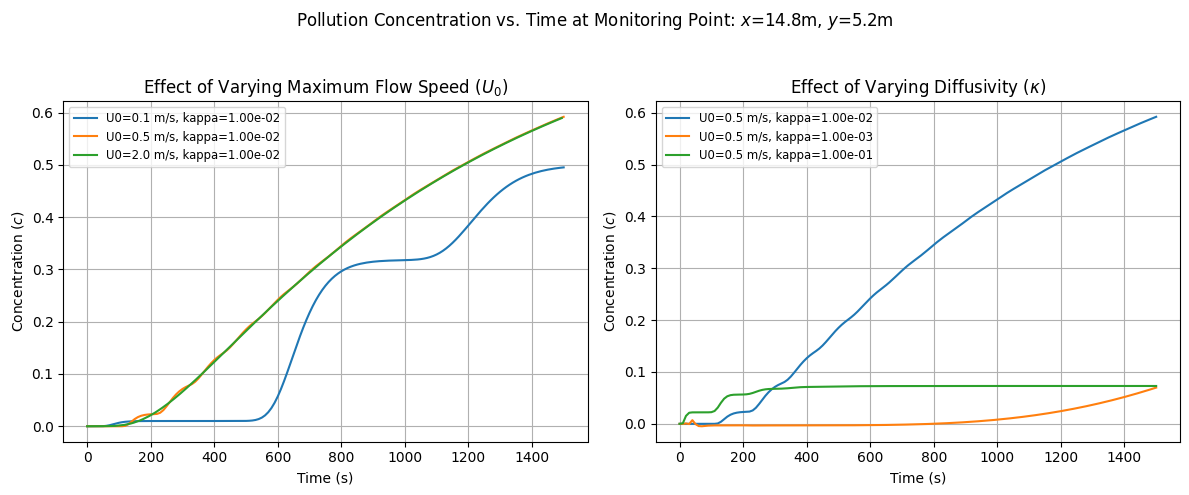

In [7]:
"""
Script to solve the time-dependent advection/diffusion equation and analyze results
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

def run_advection_diffusion(U0_val, kappa_val, L, w, Nx, Ny, stop_sim_time, S0, S_w, S_x, S_y, S_t):
    timestep = min((L / Nx) / U0_val if U0_val > 0 else 0.1, 0.1)

    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
    x, y = dist.local_grids(xbasis, ybasis)

    # Fields
    c = dist.Field(name='c', bases=(xbasis,ybasis))
    u = dist.Field(name='u', bases=(xbasis,ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the velocity field
    u['g'] = U0_val * (1 - (y - w/2)**2.0 / (w/2)**2.0) # parabolic velocity profile

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + coords.unit_vector_fields(dist)[1]*lift(tau_1)

    dx = lambda A: dedalus.Differentiate(A, coords['x'])

    S = dist.Field(name='S', bases=(xbasis,ybasis))
    # Source centered near y=0, decaying across y
    S['g'] = S0 * np.exp(-(x - S_x)**2.0 / S_w**2.0 - (y - S_y)**2.0 / S_w**2.0)

    # Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    problem.add_equation("dt(c) + u*dx(c) - kappa_val*div(grad_c) + lift(tau_2) = S/S_t")

    # Boundary conditions
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Set the solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Create arrays to periodically save the concentration field and time
    c.change_scales(1)
    c_save = [np.copy(c['g'])]
    t_save = [solver.sim_time]

    logger.info(f'Starting simulation U0={U0_val}, kappa={kappa_val}, dt={timestep}')

    #Main Loop
    try:
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration - 1) % 100 == 0: # Save every 100 steps
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except Exception as e:
        logger.error(f'Exception raised: {e}')
        # Return partial data if error occurs
        pass
    finally:
        solver.log_stats()

    # Convert the variables to numpy arrays
    c_save = np.array(c_save)
    t_save = np.array(t_save)

    return c_save, t_save, x, y, U0_val, kappa_val

# --- Global Parameters (used across all runs) ---
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y (source starts at y=0)
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time = 1500 # end time in seconds

# --- Monitoring Point (x_i, y_j) ---
x_mon_index = int(Nx * (S_x + 5) / L) # 5m downstream of source center
y_mon_index = Ny // 2 # Halfway across the river

# --- Parameter Exploration ---
results = {}

# 1. Vary U0 (Flow Speed) while keeping kappa (Diffusivity) constant
kappa_fixed = 1e-2
U0_variations = [0.1, 0.5, 2.0] # Slow, Medium, Fast
for U0_val in U0_variations:
    c_data, t_data, x_grid, y_grid, U0_out, kappa_out = run_advection_diffusion(
        U0_val, kappa_fixed, L, w, Nx, Ny, stop_sim_time, S0, S_w, S_x, S_y, S_t
    )
    # Extract concentration time series at the monitoring point
    c_ts = c_data[:, x_mon_index, y_mon_index]

    key = f'U0={U0_out:.1f} m/s, kappa={kappa_out:.2e}'
    results[key] = (t_data, c_ts)

# 2. Vary kappa (Diffusivity) while keeping U0 (Flow Speed) constant
U0_fixed = 0.5
kappa_variations = [1e-3, 1e-2, 1e-1] # Low, Medium, High
for kappa_val in kappa_variations:
    c_data, t_data, x_grid, y_grid, U0_out, kappa_out = run_advection_diffusion(
        U0_fixed, kappa_val, L, w, Nx, Ny, stop_sim_time, S0, S_w, S_x, S_y, S_t
    )
    # Extract concentration time series at the monitoring point
    c_ts = c_data[:, x_mon_index, y_mon_index]

    key = f'U0={U0_out:.1f} m/s, kappa={kappa_out:.2e}'
    results[key] = (t_data, c_ts)

# --- Plotting and Analysis ---
plt.figure(figsize=(12, 5))
x_mon = x_grid[x_mon_index, 0]
y_mon = y_grid[0, y_mon_index]
plt.suptitle(f'Pollution Concentration vs. Time at Monitoring Point: $x$={x_mon:.1f}m, $y$={y_mon:.1f}m')

# Plot 1: Effect of varying U0 (Flow Speed)
plt.subplot(1, 2, 1)
kappa_filter_str = f'kappa={kappa_fixed:.2e}'
for key, (t, c_data) in results.items():
    # Only plot runs where kappa is 1e-2 (the fixed value)
    if kappa_filter_str in key:
        plt.plot(t, c_data, label=key)
plt.xlabel('Time (s)')
plt.ylabel('Concentration ($c$)')
plt.title(r'Effect of Varying Maximum Flow Speed ($U_0$)')
plt.grid(True)
plt.legend(fontsize='small')

# Plot 2: Effect of varying kappa (Diffusivity)
plt.subplot(1, 2, 2)
U0_filter_str = f'U0={U0_fixed:.1f} m/s'
for key, (t, c_data) in results.items():
    # Only plot runs where U0 is 0.5 (the fixed value)
    if U0_filter_str in key:
        plt.plot(t, c_data, label=key)
plt.xlabel('Time (s)')
plt.ylabel('Concentration ($c$)')
plt.title(r'Effect of Varying Diffusivity ($\kappa$)')
plt.grid(True)
plt.legend(fontsize='small')

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust for suptitle
plt.show()



ANSWER - For the flow of pollution to reach the opposite side of the river, we can note that the dimensional analysis of the advection/diffusion equation will take only the diffusion state into account. This lets us know that t ~ w **2/kappa, where w is the width of the river. For the time it would take to go downstream, we consider the advective state where L ~ Ut, but from above we see that t = w **2/kappa, therefore L ~ U(w **2)/kappa.

### Turbulent diffusion
In a turbulent flow, tracers will be transported by the turbulent eddies. A common way to model this is to introduce a turbulent diffusivity, $\kappa_T\sim u*l$, where $u$ and $l$ are characteristic velocity and length scales associated with the turbulent eddies.

To explore this effect, create a Dedalus script that includes advection by $u$ and $v$ (the $x$ and $y$ components of the velocity). Then, use the same velocity field as above for $u$ and add to that a fluctuating velocity field that of the form

$$ u=u_0 cos(kx)cos(ky), \quad v=u_0 sin(kx)sin(ky) $$

where $k$ is the wavenumber associated with the velocity fluctuations and $u_0$ is the amplitude of the fluctuations. Note that $k$ should be set to give an integer number of wavelengths in the $x$ and $y$ directions. Vary both $u_0$ and $k$ and study how quicky the tracer is transported across the river. Qualitatively compare this with the expectation based on the hypothesis of turbulent diffusion.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2025-11-12 20:46:59,731 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:__main__:Starting sim: u0_fluc=0.01, k=0.6283185307179586, dt=0.1532


2025-11-12 20:46:59,737 __main__ 0/1 INFO :: Starting sim: u0_fluc=0.01, k=0.6283185307179586, dt=0.1532


INFO:solvers:Simulation stop time reached.


2025-11-12 20:47:34,866 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 9792


2025-11-12 20:47:34,869 solvers 0/1 INFO :: Final iteration: 9792


INFO:solvers:Final sim time: 1500.0000000001623


2025-11-12 20:47:34,872 solvers 0/1 INFO :: Final sim time: 1500.0000000001623


INFO:solvers:Setup time (init - iter 0): 0.3719 sec


2025-11-12 20:47:34,874 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3719 sec


INFO:solvers:Warmup time (iter 0-10): 0.1358 sec


2025-11-12 20:47:34,875 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1358 sec


INFO:solvers:Run time (iter 10-end): 34.99 sec


2025-11-12 20:47:34,878 solvers 0/1 INFO :: Run time (iter 10-end): 34.99 sec


INFO:solvers:CPU time (iter 10-end): 0.00972 cpu-hr


2025-11-12 20:47:34,879 solvers 0/1 INFO :: CPU time (iter 10-end): 0.00972 cpu-hr


INFO:solvers:Speed: 2.414e+06 mode-stages/cpu-sec


2025-11-12 20:47:34,882 solvers 0/1 INFO :: Speed: 2.414e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


2025-11-12 20:47:35,292 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


INFO:__main__:Starting sim: u0_fluc=0.1, k=0.6283185307179586, dt=0.1302


2025-11-12 20:47:35,297 __main__ 0/1 INFO :: Starting sim: u0_fluc=0.1, k=0.6283185307179586, dt=0.1302


INFO:solvers:Simulation stop time reached.


2025-11-12 20:48:18,959 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 11521


2025-11-12 20:48:18,962 solvers 0/1 INFO :: Final iteration: 11521


INFO:solvers:Final sim time: 1500.1302083331755


2025-11-12 20:48:18,967 solvers 0/1 INFO :: Final sim time: 1500.1302083331755


INFO:solvers:Setup time (init - iter 0): 0.3941 sec


2025-11-12 20:48:18,969 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3941 sec


INFO:solvers:Warmup time (iter 0-10): 0.1386 sec


2025-11-12 20:48:18,971 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1386 sec


INFO:solvers:Run time (iter 10-end): 43.52 sec


2025-11-12 20:48:18,973 solvers 0/1 INFO :: Run time (iter 10-end): 43.52 sec


INFO:solvers:CPU time (iter 10-end): 0.01209 cpu-hr


2025-11-12 20:48:18,974 solvers 0/1 INFO :: CPU time (iter 10-end): 0.01209 cpu-hr


INFO:solvers:Speed: 2.284e+06 mode-stages/cpu-sec


2025-11-12 20:48:18,977 solvers 0/1 INFO :: Speed: 2.284e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


2025-11-12 20:48:19,385 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


INFO:__main__:Starting sim: u0_fluc=0.5, k=0.6283185307179586, dt=0.0781


2025-11-12 20:48:19,389 __main__ 0/1 INFO :: Starting sim: u0_fluc=0.5, k=0.6283185307179586, dt=0.0781


INFO:solvers:Simulation stop time reached.


2025-11-12 20:49:31,051 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 19200


2025-11-12 20:49:31,053 solvers 0/1 INFO :: Final iteration: 19200


INFO:solvers:Final sim time: 1500.0


2025-11-12 20:49:31,056 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3915 sec


2025-11-12 20:49:31,059 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3915 sec


INFO:solvers:Warmup time (iter 0-10): 0.1441 sec


2025-11-12 20:49:31,061 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1441 sec


INFO:solvers:Run time (iter 10-end): 71.52 sec


2025-11-12 20:49:31,063 solvers 0/1 INFO :: Run time (iter 10-end): 71.52 sec


INFO:solvers:CPU time (iter 10-end): 0.01987 cpu-hr


2025-11-12 20:49:31,065 solvers 0/1 INFO :: CPU time (iter 10-end): 0.01987 cpu-hr


INFO:solvers:Speed: 2.317e+06 mode-stages/cpu-sec


2025-11-12 20:49:31,066 solvers 0/1 INFO :: Speed: 2.317e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 6s, Remaining: 0s, Rate: 1.7e-01/s


2025-11-12 20:49:36,858 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 6s, Remaining: 0s, Rate: 1.7e-01/s


INFO:__main__:Starting sim: u0_fluc=0.1, k=0.3141592653589793, dt=0.1302


2025-11-12 20:49:36,864 __main__ 0/1 INFO :: Starting sim: u0_fluc=0.1, k=0.3141592653589793, dt=0.1302


INFO:solvers:Simulation stop time reached.


2025-11-12 21:03:19,447 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 11521


2025-11-12 21:03:19,449 solvers 0/1 INFO :: Final iteration: 11521


INFO:solvers:Final sim time: 1500.1302083331755


2025-11-12 21:03:19,453 solvers 0/1 INFO :: Final sim time: 1500.1302083331755


INFO:solvers:Setup time (init - iter 0): 5.759 sec


2025-11-12 21:03:19,455 solvers 0/1 INFO :: Setup time (init - iter 0): 5.759 sec


INFO:solvers:Warmup time (iter 0-10): 17.87 sec


2025-11-12 21:03:19,456 solvers 0/1 INFO :: Warmup time (iter 0-10): 17.87 sec


INFO:solvers:Run time (iter 10-end): 804.7 sec


2025-11-12 21:03:19,457 solvers 0/1 INFO :: Run time (iter 10-end): 804.7 sec


INFO:solvers:CPU time (iter 10-end): 0.2235 cpu-hr


2025-11-12 21:03:19,459 solvers 0/1 INFO :: CPU time (iter 10-end): 0.2235 cpu-hr


INFO:solvers:Speed: 1.235e+05 mode-stages/cpu-sec


2025-11-12 21:03:19,460 solvers 0/1 INFO :: Speed: 1.235e+05 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2025-11-12 21:03:19,983 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:__main__:Starting sim: u0_fluc=0.1, k=1.2566370614359172, dt=0.1302


2025-11-12 21:03:19,989 __main__ 0/1 INFO :: Starting sim: u0_fluc=0.1, k=1.2566370614359172, dt=0.1302


INFO:solvers:Simulation stop time reached.


2025-11-12 21:03:57,410 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 11521


2025-11-12 21:03:57,412 solvers 0/1 INFO :: Final iteration: 11521


INFO:solvers:Final sim time: 1500.1302083331755


2025-11-12 21:03:57,413 solvers 0/1 INFO :: Final sim time: 1500.1302083331755


INFO:solvers:Setup time (init - iter 0): 0.5067 sec


2025-11-12 21:03:57,416 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5067 sec


INFO:solvers:Warmup time (iter 0-10): 0.09766 sec


2025-11-12 21:03:57,418 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.09766 sec


INFO:solvers:Run time (iter 10-end): 37.32 sec


2025-11-12 21:03:57,420 solvers 0/1 INFO :: Run time (iter 10-end): 37.32 sec


INFO:solvers:CPU time (iter 10-end): 0.01037 cpu-hr


2025-11-12 21:03:57,421 solvers 0/1 INFO :: CPU time (iter 10-end): 0.01037 cpu-hr


INFO:solvers:Speed: 2.664e+06 mode-stages/cpu-sec


2025-11-12 21:03:57,423 solvers 0/1 INFO :: Speed: 2.664e+06 mode-stages/cpu-sec


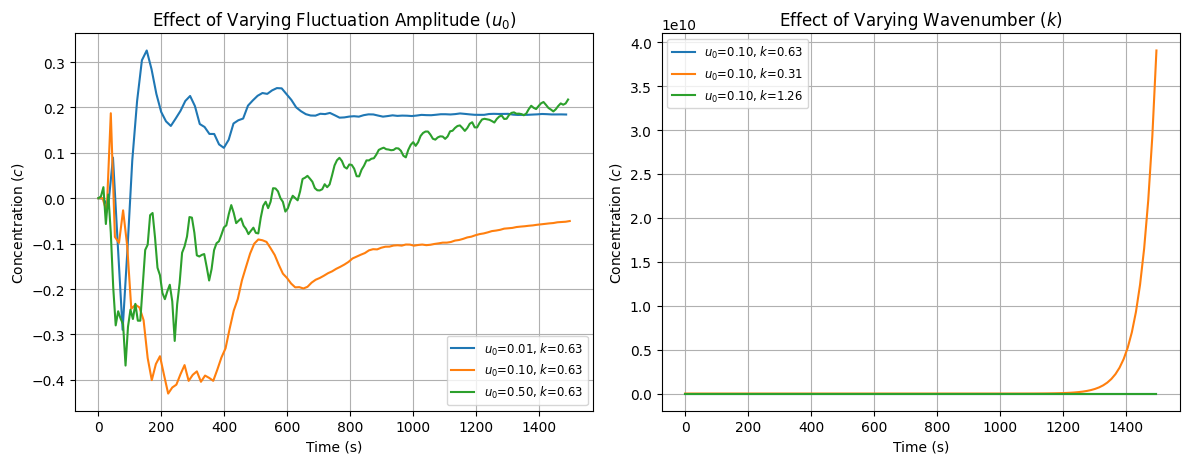

In [12]:
"""
Script to solve the time-dependent advection/diffusion equation with a fluctuating velocity field.
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# --- Function to run the simulation ---
def run_fluctuating_advection(U0_mean, u0_fluc, k_wavenumber, L, w, Nx, Ny, stop_sim_time, kappa_val, S0, S_x, S_y, S_w, S_t):
    # Numerical parameters
    # Timestep to account for the fluctuation
    max_U = U0_mean + u0_fluc
    if max_U == 0:
        timestep = 0.1 # Should not happen, but a fallback
    else:
        dx = L / Nx
        dy = w / Ny

        timestep = 0.25 * min(dx, dy) / max_U


    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
    x, y = dist.local_grids(xbasis, ybasis)

    # Fields
    c = dist.Field(name='c', bases=(xbasis,ybasis))
    u = dist.Field(name='u', bases=(xbasis,ybasis))
    v = dist.Field(name='v', bases=(xbasis,ybasis)) # New: cross-stream velocity
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the total velocity field (u_total = u_mean + u_fluc)
    u_mean = U0_mean * (1 - (y - w/2)**2.0 / (w/2)**2.0)

    # Fluctuating component definition
    u_fluc = u0_fluc * np.cos(k_wavenumber * x) * np.cos(k_wavenumber * y)
    v_fluc = u0_fluc * np.sin(k_wavenumber * x) * np.sin(k_wavenumber * y)

    u['g'] = u_mean + u_fluc # Total x-velocity
    v['g'] = v_fluc          # Total y-velocity

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)

    # The advection/diffusion equation now uses the full gradient:
    grad_c = dedalus.grad(c) + coords.unit_vector_fields(dist)[1]*lift(tau_1)

    # The full advection term: U . grad(c) = u * dx(c) + v * dy(c)
    dy = lambda A: dedalus.Differentiate(A, coords['y'])
    dx = lambda A: dedalus.Differentiate(A, coords['x'])
    advection_term = u * dx(c) + v * dy(c)

    S = dist.Field(name='S', bases=(xbasis,ybasis))
    S['g'] = S0 * np.exp(-(x - S_x)**2.0 / S_w**2.0 - (y - S_y)**2.0 / S_w**2.0)

    #Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    problem.add_equation(f"dt(c) + {advection_term} - kappa_val*div(grad_c) + lift(tau_2) = S/S_t")

    # Boundary conditions (Zero Concentration at boundaries)
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Set the solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time


    # Save concentration and time
    c.change_scales(1)
    c_save = [np.copy(c['g'])]
    t_save = [solver.sim_time]

    logger.info(f'Starting sim: u0_fluc={u0_fluc}, k={k_wavenumber}, dt={timestep:.4f}')

    # Main loop
    try:
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration - 1) % 100 == 0: # Save every 100 steps
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except Exception as e:
        logger.error(f'Exception raised: {e}')
        raise
    finally:
        solver.log_stats()

    return np.array(c_save), np.array(t_save), x, y, u0_fluc, k_wavenumber

# --- Global Parameters ---
U0_mean = 0.5 # Mean maximum current speed (m/s)
w = 10 # River width (m)
L = 50 # River length (m)
kappa_val = 1e-4 # Small background molecular diffusivity (m^2/s)
S0 = 1 # Source amplitude
S_w = 1 # Source width (m)
S_x = 10 # Source center in x (m)
S_y = 0 # Source center in y (m)
S_t = 1 # Source timescale

# Numerical parameters
Nx = 128 # Gridpoints in x (reduced for faster testing)
Ny = 32 # Gridpoints in y
stop_sim_time = 1500 # End time in seconds

# --- Parameter Variation ---
results = {}


k_base = 2 * np.pi / w

# 1. Vary Amplitude (u0_fluc) while keeping Wavenumber (k) constant
k_fixed = k_base
u0_variations = [0.01, 0.1, 0.5] # Small, Medium, Large Fluctuation Amplitude

for u0 in u0_variations:

    c_data, t_data, x_grid, y_grid, u0_out, k_out = run_fluctuating_advection(
        U0_mean, u0, k_fixed, L, w, Nx, Ny, stop_sim_time, kappa_val, S0, S_x, S_y, S_w, S_t
    )
    # Monitor Concentration at the opposite bank (y=w) slightly downstream
    x_mon_index = np.argmin(np.abs(x_grid[:, 0] - (S_x + 5)))
    y_mon_index = Ny - 1 # Opposite bank

    c_ts = c_data[:, x_mon_index, y_mon_index]
    key = f'u0_var={u0_out:.2f} m/s, k= {k_out:.2e}'
    results[key] = (t_data, c_ts, u0_out, k_out)

# 2. Vary Wavenumber (k) while keeping Amplitude (u0_fluc) constant
u0_fixed = 0.1
k_variations = [k_base / 2, k_base, k_base * 2] # Large, Medium, Small Eddy Size

for k_val in k_variations:
    if np.isclose(k_val, k_fixed) and np.isclose(u0_fixed, 0.1):
        continue

    c_data, t_data, x_grid, y_grid, u0_out, k_out = run_fluctuating_advection(
        U0_mean, u0_fixed, k_val, L, w, Nx, Ny, stop_sim_time, kappa_val, S0, S_x, S_y, S_w, S_t
    )
    # Monitor Concentration at the opposite bank (y=w) slightly downstream
    x_mon_index = np.argmin(np.abs(x_grid[:, 0] - (S_x + 5)))
    y_mon_index = Ny - 1 # Opposite bank

    c_ts = c_data[:, x_mon_index, y_mon_index]
    key = f'U0_fixed={U0_fixed:.2f} m/s, k_var= {k_out:.2e}'
    results[key] = (t_data, c_ts, u0_fixed, k_out)

# --- Plotting and Analysis ---
plt.figure(figsize=(12, 5))
x_mon = x_grid[x_mon_index, 0]
y_mon = y_grid[0, y_mon_index]


# Plot 1: Effect of varying u0 (Fluctuation Amplitude)
plt.subplot(1, 2, 1)
plt.title(r'Effect of Varying Fluctuation Amplitude ($u_0$)')
for key, (t, c_data, u0_out, k_out) in results.items():
    if 'u0_var' in key:
        plt.plot(t, c_data, label=r'$u_0$=' + f'{u0_out:.2f}' + r', $k$=' + f'{k_out:.2f}')
plt.xlabel('Time (s)')
plt.ylabel('Concentration ($c$)')
plt.grid(True)
plt.legend(fontsize='small')

# Plot 2: Effect of varying k (Wavenumber/Eddy Size)
plt.subplot(1, 2, 2)
plt.title(r'Effect of Varying Wavenumber ($k$)')
for key, (t, c_data, u0_out, k_out) in results.items():
    if np.isclose(u0_out, u0_fixed):
        plt.plot(t, c_data, label=r'$u_0$=' + f'{u0_out:.2f}' + r', $k$=' + f'{k_out:.2f}')
plt.xlabel('Time (s)')
plt.ylabel('Concentration ($c$)')
plt.grid(True)
plt.legend(fontsize='small')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


ANSWER - The hypothesis of turbulent diffusion, while similar to molecular diffusion , shows that the transport rates of pollutants are larger due to the turbulent eddies marked by the eddies/turbulent diffusivity. From the graph, we can see that as the amplitude is increased the quicker it takes for the concentration of the pollutant to reach a steady state. This is because of increased turbulence and mixing, which increases the rate of dilution of the pollutant and a reduction in the concentration from the source. When the wavelength is fluctuated, we see that at higher wavelengths, the liquid is dispersed to a greater distance but also increases the rate of diffusion due to increased turbulence. Basically, the transport of the pollutant strongly depends on both amplitude and wavelength

## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.